In [1]:
import pandas as pd
import os
from backtesting.anomaly_detector_mt5.anomaly_detector_mt5 import BacktestIsolationForestAnomalyDetector
from backtesting.sentiment_analyzer_mt5.sentiment_analyzer_mt5 import BacktestSentimentAnalyzer
from backtesting.platform_conector_mt5.platform_connector_mt5 import BacktestPlatformConnector
from backtesting.data_source_mt5.data_source_mt5 import MT5BacktestDataSource
from portfolio.portfolio import Portfolio
from backtesting_director.backtesting_director import BacktestingDirector
from strategy_manager.strategy_manager import StrategyManager
from strategy_manager.properties.strategy_manager_properties import MACrossoverProps, RSIProps
from position_sizer.position_sizer import PositionSizer
from position_sizer.properties.position_sizer_properties import FixedSizingProps
from risk_manager.risk_manager import RiskManager
from risk_manager.properties.risk_manager_properties import MaxLeverageFactorRiskProps
from backtesting.data_display_mt5.data_display_mt5 import DataDisplayMT5
from backtesting.order_executor_mt5.order_executor_mt5 import BacktestOrderExecutor
from queue import Queue

c:\Users\ronaldjaviervezgarue\anaconda3\envs\TradingFramework\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
symbols = ["EURUSD"]
timeframe = "H1"
magic_number = 12345
volume = 0.10
max_leverage_factor = 5
start_date = "2023-01-01"
end_date = "2023-12-30"
csv_sentiment_file_path = r"c:\Mac\Home\Documents\PythonTradingBot\src\backtesting\dataset\eurusd_news_2023.csv"
USE_BACKTEST_SENTIMENT_ANALYZER = True
USE_BACKTEST_ANOMALY_DETECTOR = True

mac_props = MACrossoverProps(
    timeframe=timeframe,
    slow_period=10,
    fast_period=5,
)

rsi_props = RSIProps(
    timeframe=timeframe,
    rsi_period=14,
    rsi_upper=70.0,
    rsi_lower=30.0,
    sl_points=200,
    tp_points=400,
)

events_queue = Queue()

BACKTEST_CONNECT = BacktestPlatformConnector()
initial_balance = BACKTEST_CONNECT.get_balance()

BACKTEST_DATA_SOURCE = MT5BacktestDataSource(events_queue=events_queue, symbols=symbols, timeframe=timeframe,
                                    start_date=start_date, end_date=end_date)

PORTFOLIO = Portfolio(magic_number=magic_number, platform_connector=BACKTEST_CONNECT)

BACKTEST_ORDER_EXECUTOR = BacktestOrderExecutor(
    platform_connector=BACKTEST_CONNECT,
    events_queue=events_queue,
    data_source=BACKTEST_DATA_SOURCE,
    portfolio=PORTFOLIO
)

BACKTEST_SENTIMENT_ANALYZER = None
if USE_BACKTEST_SENTIMENT_ANALYZER:
    if csv_sentiment_file_path and os.path.exists(csv_sentiment_file_path):
        print(f"Bactest Sentiment Analysis enabled with this csv file: {csv_sentiment_file_path}")
        BACKTEST_SENTIMENT_ANALYZER = BacktestSentimentAnalyzer(csv_file_path=csv_sentiment_file_path)
    else:
        print("WARN: Bactest Sentiment Analysis enabled but csv file not found news fetching will fail.")
        BACKTEST_SENTIMENT_ANALYZER = BacktestSentimentAnalyzer(csv_file_path=csv_sentiment_file_path)
else:
    print("Bactest Sentiment Analysis is disabled by configuration.")

BACKTEST_ANOMALY_DETECTOR = None
if USE_BACKTEST_ANOMALY_DETECTOR:
    all_data_df = BACKTEST_DATA_SOURCE.get_all_data() 

    if not all_data_df.empty:
        anomaly_window_size = 20
        anomaly_features_to_use = ['open', 'high', 'low', 'close', 'tickvol', 'vol', 'spread'] 
        
        missing_anomaly_features = [f for f in anomaly_features_to_use if f not in all_data_df.columns]
        if not missing_anomaly_features:
            BACKTEST_ANOMALY_DETECTOR = BacktestIsolationForestAnomalyDetector(
                window_size=anomaly_window_size,
                features=anomaly_features_to_use,
                random_state=42,
                contamination='auto'
            )
            train_anomaly_df_size = int(len(all_data_df) * 0.7)
            train_anomaly_df = all_data_df.iloc[:train_anomaly_df_size]

            if len(train_anomaly_df) >= anomaly_window_size + 1:
                print(f"Training anomaly detector with {len(train_anomaly_df)} data points...")
                try:
                    BACKTEST_ANOMALY_DETECTOR.fit(train_anomaly_df)
                    BACKTEST_ANOMALY_DETECTOR.set_threshold_from_train_data(percentile=95) 
                    print("Anomaly detector training completed.")
                except ValueError as e:
                    print(f"Error training anomaly detector: {e}")
                    BACKTEST_ANOMALY_DETECTOR = None
            else:
                print(
                f"Not enough data ({len(train_anomaly_df)}) to train the anomaly detector "
                f"with window size {anomaly_window_size}. The anomaly detector will be disabled."
            )
                BACKTEST_ANOMALY_DETECTOR = None
        else:
            print(f"Anomaly detector disabled. Missing features in historical data: {missing_anomaly_features}")
            BACKTEST_ANOMALY_DETECTOR = None
    else:
        print("No historical data available to train the anomaly detector. The anomaly detector will be disabled.")
else:
    print("Backtest Anomaly Detector is disabled by configuration.")

STRATEGY_MANAGER = StrategyManager(
    events_queue=events_queue,
    data_source=BACKTEST_DATA_SOURCE,
    portfolio=PORTFOLIO,
    order_executor=BACKTEST_ORDER_EXECUTOR,
    strategy_properties=mac_props,
    sentiment_analyzer=BACKTEST_SENTIMENT_ANALYZER,
    anomaly_detector=BACKTEST_ANOMALY_DETECTOR
)

POSITION_SIZER = PositionSizer(
    events_queue=events_queue,
    data_source=BACKTEST_DATA_SOURCE,
    sizing_properties=FixedSizingProps(volume=volume)
)

RISK_MANAGER = RiskManager(
    events_queue=events_queue,
    data_source=BACKTEST_DATA_SOURCE,
    portfolio=PORTFOLIO,
    risk_properties=MaxLeverageFactorRiskProps(max_leverage_factor=max_leverage_factor)
)

BACKTESTING_DIRECTOR = BacktestingDirector(
    events_queue=events_queue,
    data_source=BACKTEST_DATA_SOURCE,
    strategy_manager=STRATEGY_MANAGER,
    position_sizer=POSITION_SIZER,
    risk_manager=RISK_MANAGER,
    order_executor=BACKTEST_ORDER_EXECUTOR,
)

BACKTESTING_DIRECTOR.run()

print("\n--- Backtest Finished ---")
print(f"Initial Balance: {initial_balance:.2f}")
final_balance = BACKTEST_CONNECT.get_balance()
print(f"Final Balance: {final_balance:.2f}")
print(f"Final Equity: {BACKTEST_CONNECT.get_equity():.2f}")

trade_log_df = pd.DataFrame(BACKTEST_ORDER_EXECUTOR.get_trade_log())

Bactest Sentiment Analysis enabled with this csv file: c:\Mac\Home\Documents\PythonTradingBot\src\backtesting\dataset\eurusd_news_2023.csv


c:\Users\ronaldjaviervezgarue\anaconda3\envs\TradingFramework\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


INFO: Loading news data from CSV: c:\Mac\Home\Documents\PythonTradingBot\src\backtesting\dataset\eurusd_news_2023.csv
INFO: Successfully loaded and preprocessed 2295 news items from CSV.
Training anomaly detector with 4351 data points...
Isolation Forest model training completed.
Anomaly threshold set to: 0.05955 (based on the 95 percentile of training decision scores)
Anomaly detector training completed.
2025-06-22 19:29:51 - Receiving DATA EVENT from: EURUSD - last close price: 1.06898
2025-06-22 19:29:51 - Receiving DATA EVENT from: EURUSD - last close price: 1.07056
2025-06-22 19:29:51 - Receiving DATA EVENT from: EURUSD - last close price: 1.07071
2025-06-22 19:29:51 - Receiving DATA EVENT from: EURUSD - last close price: 1.06984
2025-06-22 19:29:51 - Receiving DATA EVENT from: EURUSD - last close price: 1.06952
2025-06-22 19:29:51 - Receiving DATA EVENT from: EURUSD - last close price: 1.06958
2025-06-22 19:29:51 - Receiving DATA EVENT from: EURUSD - last close price: 1.07017
202

In [3]:
if not trade_log_df.empty:
    print("\n--- Trade Log ---")
    print(trade_log_df.head())

else:
    print("No trades were executed.")


--- Trade Log ---
                                 ticket  symbol open_side  entry_price  \
0  7c2f1c90-fbb2-40cc-a5e0-90aa78373c55  EURUSD      sell      1.06787   
1  75d48074-7432-46f4-8a06-b3af8098bc62  EURUSD       buy      1.06770   
2  81f3291a-1b31-4d69-a636-117ca623da05  EURUSD      sell      1.06240   
3  1b81c763-285c-4412-a89f-e6ba0ec2b7e5  EURUSD       buy      1.05581   
4  af4f4b34-8112-4367-ba65-9cf5a469f511  EURUSD      sell      1.05488   

           entry_time  volume close_side  exit_price           exit_time  \
0 2023-01-02 09:00:00     0.1        buy     1.06770 2023-01-03 01:00:00   
1 2023-01-03 01:00:00     0.1       sell     1.06240 2023-01-03 09:00:00   
2 2023-01-03 09:00:00     0.1        buy     1.05581 2023-01-03 18:00:00   
3 2023-01-03 18:00:00     0.1       sell     1.05488 2023-01-03 23:00:00   
4 2023-01-03 23:00:00     0.1        buy     1.05650 2023-01-04 04:00:00   

   profit  magic   sl   tp  
0     1.7  12345  0.0  0.0  
1   -53.0  12345  0.0

In [4]:
if not trade_log_df.empty:
    display = DataDisplayMT5(trade_log_df=trade_log_df, initial_balance=initial_balance)
    display.display_summary()

else:
    print("No trades were executed.")


--- Backtest Summary ---
Total Intentos Registrados: 662
Operaciones Canceladas por Sentiment Analyzer: N/A (columna 'cancellation_reason' no disponible)
Total Operaciones Ejecutadas: 662
Total Profit/Loss: 333.40
Gross Profit: 6592.40
Gross Loss: -6259.00
Winning Trades: 256
Losing/Neutral Trades: 406
Win Rate (%): 38.67
Average Win ($): 25.75
Average Loss ($): -15.45
Profit Factor: 1.05
Max Drawdown ($): -728.20
Max Drawdown (%): 71.77
Sharpe Ratio (simplificado): 0.27
---------------------------



{'Total Intentos Registrados': 662, 'Operaciones Canceladas por Sentiment Analyzer': "N/A (columna 'cancellation_reason' no disponible)", 'Total Operaciones Ejecutadas': 662, 'Total Profit/Loss': 333.4000000000215, 'Gross Profit': 6592.400000000041, 'Gross Loss': -6259.000000000019, 'Winning Trades': 256, 'Losing/Neutral Trades': 406, 'Win Rate (%)': 38.670694864048336, 'Average Win ($)': 25.75156250000016, 'Average Loss ($)': -15.454320987654368, 'Profit Factor': 1.0532672950950663, 'Max Drawdown ($)': -728.2000000000169, 'Max Drawdown (%)': 71.77212694658158, 'Sharpe Ratio (simplificado)': 0.27285372405475933}...


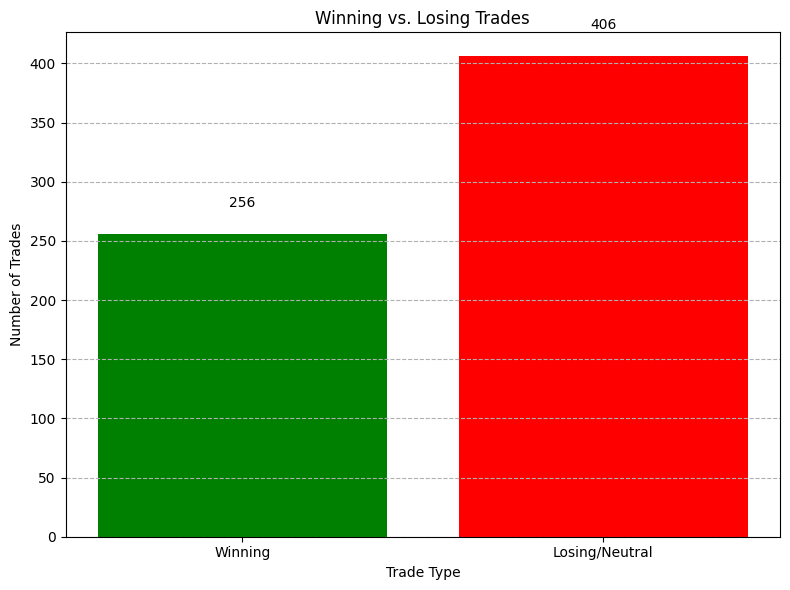

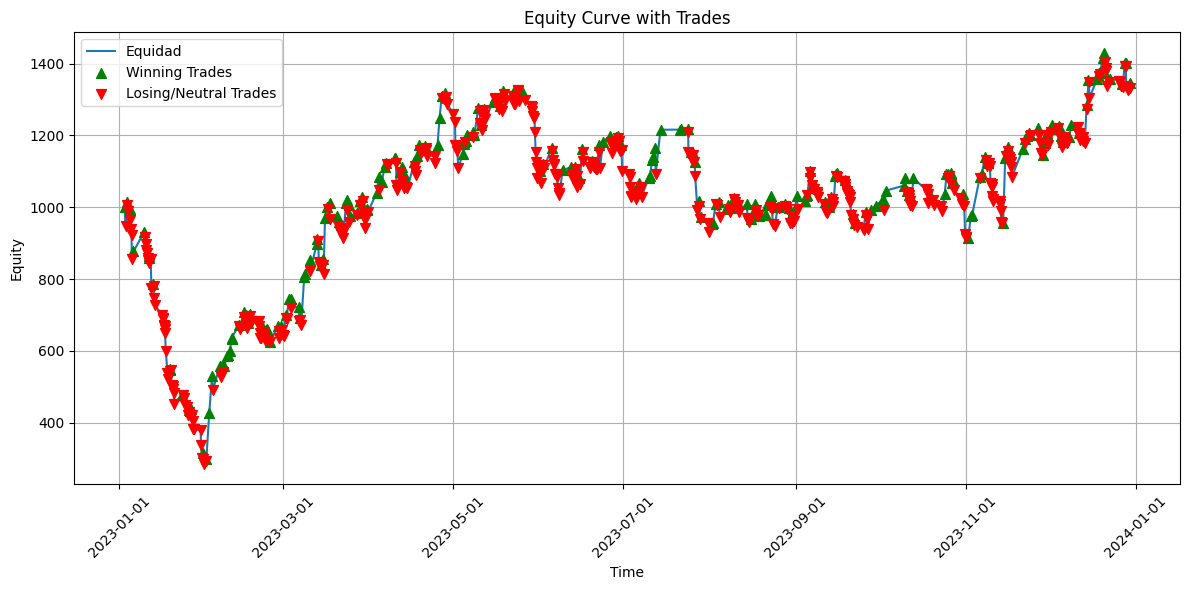

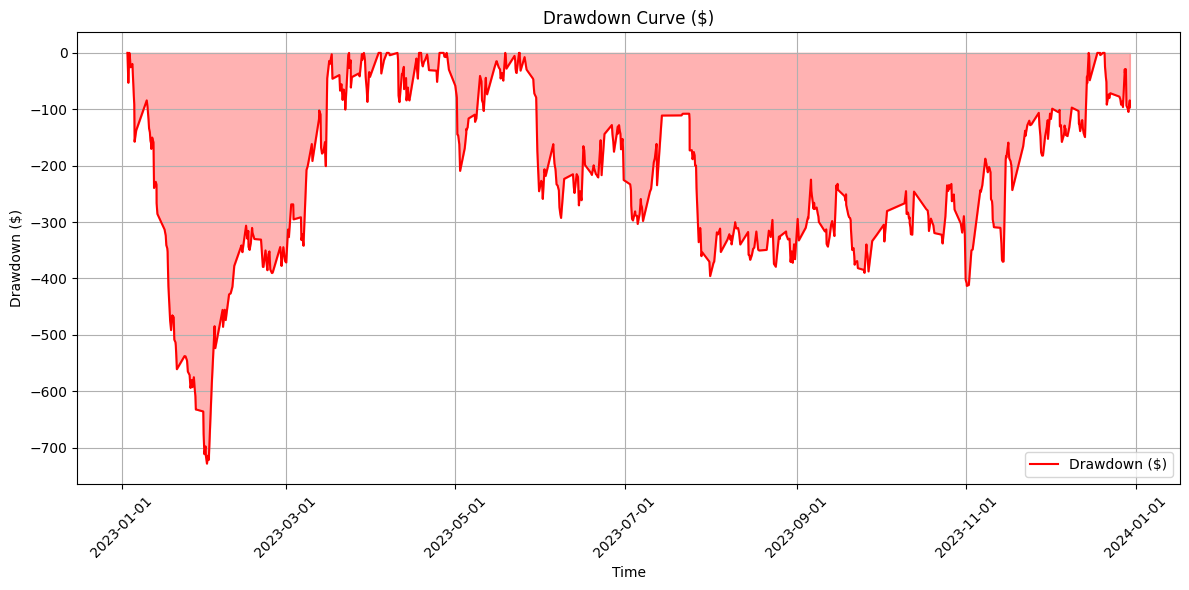

In [5]:
if not trade_log_df.empty:
    display.plot_win_loss_trades_bar_chart()
    display.plot_equity_curve_and_trades()
    display.plot_drawdown_curve()

else:
    print("No trades were executed.")